# model

Please refer to README file for project overview.

# Set execution parameters

In [1]:
data_dir = "../_DATA/CarND_behavioral_cloning/r_001/"
image_final_width = 64
driving_data_csv = "driving_log_normalized.csv"
processed_images_dir = "processed_images/"

model_dir = "../_DATA/MODELS/"
model_name = "model_p3_14x64x3_"
batch_size = 64
nb_epoch = 3 
# 30 epochs = 55 minutes on MacBook Pro

# CONTINUE TRAINING ?
should_retrain_existing_model = True
model_to_continue_training = "model_p3_keras_tf_mini_14x64x3__epoch_30_val_acc_0.402555912543.h5"
previous_trained_epochs = 30

# Python Imports

In [2]:
import matplotlib.pyplot as plt

# import matplotlib.image as mpimg
# from scipy import misc
# import cv2

import DataHelper
#print(DataHelper.__doc__)

Using TensorFlow backend.


In [3]:
# https://github.com/aymericdamien/TensorFlow-Examples/issues/38#issuecomment-265599695
import tensorflow as tf

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5) #0.333
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True, gpu_options=gpu_options))


from tensorflow.python.client import device_lib

def get_available_CPU_GPU():
    devices = device_lib.list_local_devices()
    #return [x.name for x in devices if x.device_type == 'CPU']
    return [x.name for x in devices ]

print(get_available_CPU_GPU())

['/cpu:0', '/gpu:0']


# Fetch CSV driving data

In [4]:
from  DataHelper import read_csv

print(data_dir + driving_data_csv)
headers, data = read_csv(data_dir + driving_data_csv)

../_DATA/CarND_behavioral_cloning/r_001/driving_log_normalized.csv
Number of imported CSV rows: 11723


# Split Training, Testing and Validation sets

Keras actually does it's own training/testing split, so here I just reserve small validation set.

In [5]:
from DataHelper import split_random

training, testing, validation = split_random(data, percent_train=85, percent_test=15) 

print("training", training.shape)
print("testing", testing.shape)
print("validation", validation.shape)

percent_validation 0
training (9964, 7)
testing (1758, 7)
validation (0, 7)


# Fetch steering angles

min_value -0.842961
max_value 0.965902
spread 1.80886
recommended number of classes 181


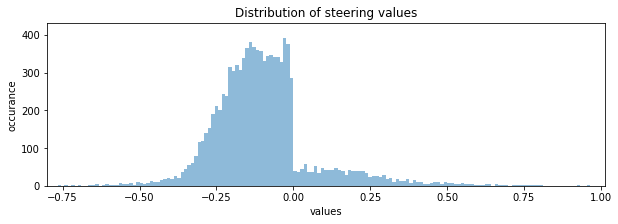

In [6]:
from DataHelper import plot_histogram, get_steering_values, find_nearest

steering_angles = get_steering_values(training)

change_step=0.01 # test data changes
plot_histogram("steering values", steering_angles, change_step)

# Create discrete 41 steering classes

- I might consider rounding the steering angles to lower amount of training
- I assume the classification labels to be float values

steering_classes [-1.         -0.94999999 -0.89999998 -0.85000002 -0.80000001 -0.75
 -0.69999999 -0.64999998 -0.60000002 -0.55000001 -0.5        -0.44999999
 -0.40000001 -0.34999999 -0.30000001 -0.25       -0.2        -0.15000001
 -0.1        -0.05        0.          0.05        0.1         0.15000001
  0.2         0.25        0.30000001  0.34999999  0.40000001  0.44999999
  0.5         0.55000001  0.60000002  0.64999998  0.69999999  0.75
  0.80000001  0.85000002  0.89999998  0.94999999  1.        ] <class 'numpy.float32'>
Number of created classes 41


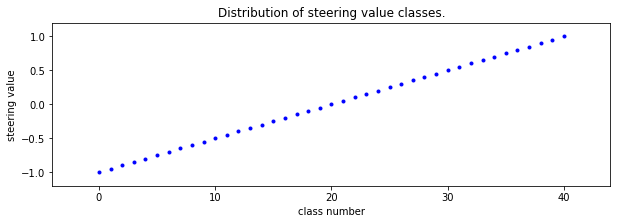

In [7]:
import numpy as np
from numpy import ndarray
from DataHelper import create_steering_classes, plot_steering_values

steering_classes = create_steering_classes(number_of_classes = 41).astype(np.float32)

# ROUNDING is a hopeless effort
# steering_classes = np.round(steering_classes, 2)

print("steering_classes", steering_classes, type(steering_classes[0]))
number_of_classes = steering_classes.shape[0]
print("Number of created classes", number_of_classes)

plot_steering_values(values = steering_classes)

## Snap the ACTUAL steering angles to newly created classes

In [8]:
training_labels = np.array([], dtype=np.float32)

for actual_steering_angle in steering_angles:
    rounded_value = find_nearest(steering_classes, actual_steering_angle).astype(np.float32)
    training_labels = np.append(training_labels, [rounded_value])
        
print(training_labels[0:50], type(training_labels[0]))

[ 0.1        -0.05       -0.30000001 -0.2        -0.25       -0.34999999
 -0.15000001 -0.15000001 -0.1        -0.1        -0.2        -0.15000001
 -0.15000001 -0.05       -0.05       -0.1         0.         -0.25       -0.2
  0.          0.05       -0.05       -0.05       -0.25       -0.15000001
 -0.25       -0.1         0.15000001  0.         -0.30000001 -0.30000001
  0.25       -0.25       -0.1         0.55000001 -0.1         0.         -0.1
 -0.1         0.15000001 -0.15000001  0.34999999 -0.05       -0.15000001
  0.1         0.         -0.2        -0.15000001 -0.15000001 -0.15000001] <class 'numpy.float32'>


min_value -0.85
max_value 0.95
spread 1.8
recommended number of classes 180


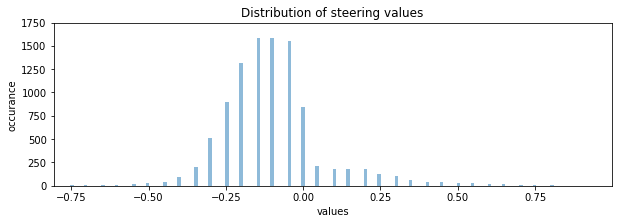

In [9]:
plot_histogram("steering values", training_labels, change_step=0.01)

## Test conversion form actual to class label

In [10]:
from random import randrange

sample_index = randrange(0,len(steering_angles))
print("actual:", steering_angles[sample_index], "class:",training_labels[sample_index])

sample_index = randrange(0,len(steering_angles))
print("actual:", steering_angles[sample_index], "class:",training_labels[sample_index])

sample_index = randrange(0,len(steering_angles))
print("actual:", steering_angles[sample_index], "class:",training_labels[sample_index])

actual: -0.20568 class: -0.2
actual: -0.0562921 class: -0.05
actual: -0.206004 class: -0.2


## Encoding Training Labels in one-hot notation

In [11]:
from DataHelper import encode_one_hot, locate_one_hot_position

y_one_hot =  encode_one_hot(defined_classes=steering_classes, sample_labels=training_labels)

print("y_one_hot", y_one_hot.shape)

defined_classes
 [-1.         -1.         -0.89999998 -0.80000001 -0.80000001 -0.80000001
 -0.69999999 -0.60000002 -0.60000002 -0.60000002 -0.5        -0.40000001
 -0.40000001 -0.40000001 -0.30000001 -0.2        -0.2        -0.2        -0.1
 -0.          0.          0.          0.1         0.2         0.2         0.2
  0.30000001  0.40000001  0.40000001  0.40000001  0.5         0.60000002
  0.60000002  0.60000002  0.69999999  0.80000001  0.80000001  0.80000001
  0.89999998  1.          1.        ]
class_count: 41
sample_count: 9964
one_hot examples 
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]]
one_hot shape (9964, 41)
y_one_hot (9964, 41)


### One-hot print and verify

In [12]:
for index in range(5):
    print( "training label", training_labels[index], "is @", 
          locate_one_hot_position(steering_classes, training_labels[index] ), 
          "\n", y_one_hot[index] )

training label 0.1 is @ 22 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
training label -0.05 is @ 19 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
training label -0.3 is @ 14 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
training label -0.2 is @ 16 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
training label -0.25 is @ 15 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]


# Extract training features (images)

In [13]:
from DataHelper import get_image_center_values 

image_names = get_image_center_values(training)
print(image_names.shape)
print(image_names[1])

(9964,)
center_2017_01_21_00_21_39_833.jpg


## Create a list of image paths pointing to 64px version

In [14]:
image_paths = []
for image_name in image_names:
    image_paths.extend([data_dir + processed_images_dir + image_name])
print(image_paths[1]) 

../_DATA/CarND_behavioral_cloning/r_001/processed_images/center_2017_01_21_00_21_39_833.jpg


## Read actual (preprocessed) images from the disk

training_features matrix shape (9964, 14, 64, 3)


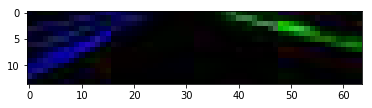

[[ 0  0 21]
 [ 0  0 10]
 [ 0  6  0]
 [ 0  9  0]
 [ 0  9  0]
 [ 0  7  3]
 [ 0  0 13]
 [ 0  0 24]
 [ 0  0 32]
 [ 0  0 29]
 [ 0  0 25]
 [ 0  0 27]
 [ 0  0 44]
 [ 5  5 65]
 [10  7 86]]


In [15]:
from DataHelper import read_image

training_features = np.array([ read_image(path) for path in image_paths] )

print ("training_features matrix shape", training_features.shape)

sample_image = training_features[2]
plt.imshow(sample_image) # cmap='gray' , cmap='rainbow'
plt.show()

print(sample_image[0][0:15])

# Keras (with TensorFlow)

https://keras.io/layers/convolutional/

In [16]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import ELU
from keras.layers.core import Flatten, Dense, Dropout, Activation, Lambda

from keras.activations import relu, softmax
from keras.optimizers import SGD
import cv2, numpy as np
from DataHelper import mean_pred, false_rates

from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, Convolution1D

### X Import Model_Keras_VGG_16.py

This file (in the same directory) contains MODEL definiteion for VGG.16.

### X Adjust VGG.16 model architecture to match my needs

# Build my own custom model

In [17]:
from keras.layers import InputLayer, Input

# activation = "relu" | "elu"

model = Sequential()

model.add(Convolution2D(32, 3, 3, border_mode='same', activation="relu" ,
                        input_shape=(14, 64 ,3), dim_ordering='tf', name="conv2d_1_relu"))
model.add(Convolution2D(32, 3, 3, border_mode='same', activation="relu", name="conv2d_2_relu" ))
model.add(Convolution2D(32, 5, 5, border_mode='same', activation="relu", name="conv2d_3_relu" ))

model.add(Flatten())

#model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dense(256, activation="relu", name="dense_1_relu")) #256
model.add(Dropout(0.25, name="dropout_1_0.25"))
model.add(Dense(256, activation="relu", name="dense_2_relu" )) #256

# CLASSIFICATION
model.add(Dense(41, activation='linear' , name="dense_3_41_linear")) # default: linear | softmax | relu | sigmoid

# REGRESSION
#model.add(Dense(1, activation='linear'))

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
conv2d_1_relu (Convolution2D)    (None, 14, 64, 32)    896         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
conv2d_2_relu (Convolution2D)    (None, 14, 64, 32)    9248        conv2d_1_relu[0][0]              
____________________________________________________________________________________________________
conv2d_3_relu (Convolution2D)    (None, 14, 64, 32)    25632       conv2d_2_relu[0][0]              
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 28672)         0           conv2d_3_relu[0][0]              
___________________________________________________________________________________________

# Compile model (configure learning process)

In [18]:
# Before training a model, you need to configure the learning process, which is done via the compile method.
# 
# keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

optimizer='sgd' # | 'rmsprop'
loss_function="mse" # | 'binary_crossentropy' | 'mse' | mean_squared_error | sparse_categorical_crossentropy
metrics_array=['accuracy'] # , mean_pred, false_rates

model.compile(optimizer, loss_function, metrics_array)

# Replace model with one stored on disk

- If you replace the model, the INPUT dimetions have to be the same as these trained
- Name your models well

# Train (fit) the model agaist given labels

In [19]:
# REGRESSION
# history = model.fit(training_features, training_labels, nb_epoch=nb_epoch, 
#                    batch_size=batch_size, verbose=1, validation_split=0.2)

# CLASSIFICATION
history = model.fit(training_features, y_one_hot, nb_epoch=nb_epoch, 
                    batch_size=batch_size, verbose=1, validation_split=0.2)

Train on 7971 samples, validate on 1993 samples
Epoch 1/3
7971/7971 [==============================] - 24s - loss: 0.2050 - acc: 0.1242 - val_loss: 0.0230 - val_acc: 0.2614

In [20]:
# list all data in history
print(history.history.keys())

training_accuracy = str( history.history['acc'][nb_epoch-1])
print("training_accuracy", training_accuracy)

training_error = str( history.history['loss'][nb_epoch-1])
print("training_error", training_error)

validation_accuracy = str( history.history['val_acc'][nb_epoch-1])
print("validation_accuracy", validation_accuracy)

validation_error = str( history.history['val_loss'][nb_epoch-1])
print("validation_error", validation_error)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
training_accuracy 0.36105883833
training_error 0.0215222597447
validation_accuracy 0.364274962413
validation_error 0.020642372308


# Save the model

In [21]:
# creates a HDF5 file '___.h5'
model.save(model_dir + model_name + "_epoch_" + str(nb_epoch + previous_trained_epochs) 
           + "_val_acc_" + str(validation_accuracy) + ".h5") 
#del model  # deletes the existing model
#model = load_model('my_model.h5')

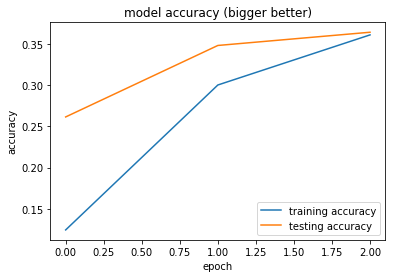

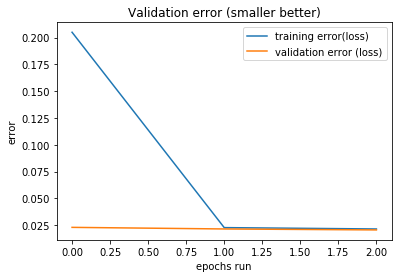

In [22]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy (bigger better)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy', 'testing accuracy'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Validation error (smaller better)')
plt.ylabel('error')
plt.xlabel('epochs run')
plt.legend(['training error(loss)', 'validation error (loss)'], loc='upper right')
plt.show()

# Prediction

../_DATA/CarND_behavioral_cloning/r_001/processed_images/center_2017_01_21_01_10_33_504.jpg
(14, 64, 3)


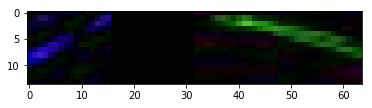

In [23]:
image_name = "center_2016_12_01_13_32_43_659.jpg" # stering 0.05219137
original_steering_angle = 0.05219137

image_name = "center_2016_12_01_13_33_10_579.jpg" # 0.1287396
original_steering_angle = 0.05219137

image_name = "center_2017_01_21_01_10_33_504.jpg" # -0.8188741
original_steering_angle = -0.8188741

image_path =  data_dir + processed_images_dir + image_name
print(image_path)
image = read_image(image_path)
print(image.shape)
plt.imshow(image, cmap='gray')
plt.show()

## Run model.predict(image)

In [24]:
predictions = model.predict( image[None, :, :], batch_size=1, verbose=1)

1/1 [==============================] - 0s


## Extract top prediction

In [25]:
from DataHelper import predict_class

predicted_class = predict_class(predictions, steering_classes)

print("original steering angle \n", original_steering_angle)
print("top_prediction \n", predicted_class )

predicted class: -0.25 	 17.1 %
predicted class: -0.1 	 13.3 %
predicted class: -0.45 	 9.3 %
original steering angle 
 -0.8188741
top_prediction 
 -0.25


## Plot predictions (peaks are top classes)

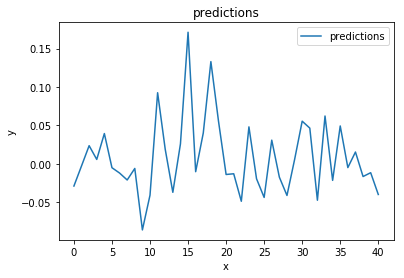

In [26]:
# summarize history for loss
plt.plot(predictions[0])
plt.title('predictions')
plt.ylabel('y')
plt.xlabel('x')
plt.legend(['predictions'], loc='upper right')
plt.show()